## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from ipywidgets import interact, interactive, fixed
from scipy.misc import imsave
%matplotlib inline

## First, I'll compute the camera calibration using chessboard images

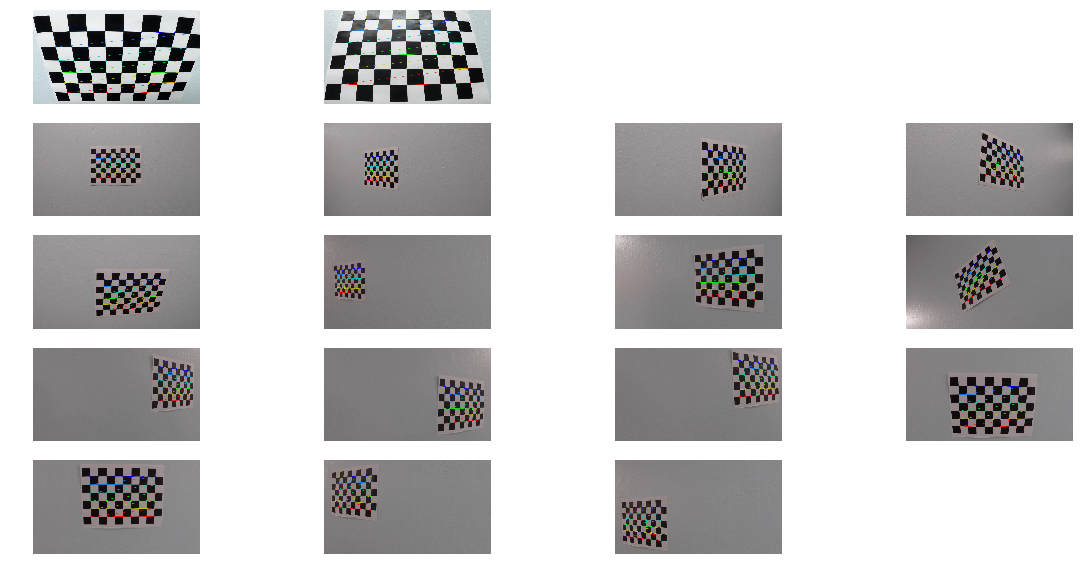

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


plt.figure(figsize=(20, 10))
# Step through the list and search for chessboard corners; grayscale is required for findChessboardCorners()
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
   
    # Find the chessboard corners
    # ret is a Boolean; if True, then corner values are returned
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw, save and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        write_name = './output_images4/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        plt.subplot(5, 4, idx)
        plt.axis('off')
        plt.imshow(img)

## Distortion Correction

In [3]:
# Test undistortion on a chessboard image 
chess_img = cv2.imread('./camera_cal/calibration01.jpg')
chess_img = cv2.cvtColor(chess_img, cv2.COLOR_BGR2RGB)
chess_img_size = (img.shape[1], img.shape[0])

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, chess_img_size, None, None)
undist_chess = cv2.undistort(chess_img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs/tvecs)
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
dist_pickle['objpoints'] = objpoints
dist_pickle['imgpoints'] = imgpoints

# Uncomment below to save
#pickle.dump(dist_pickle, open('calibration_pickle2.p', 'wb'))

print('Done')

Done


Done


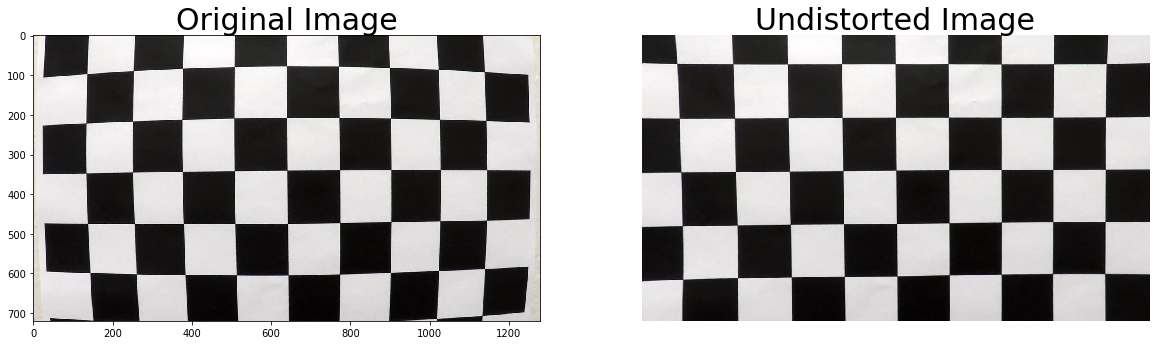

In [4]:
with open('calibration_pickle2.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(chess_img)
plt.axis('off')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_chess)
ax2.set_title('Undistorted Image', fontsize=30)
plt.axis('off')
# Uncomment below to save
#plt.savefig('./output_images4/camera_calibration_chess.jpg')

print('Done')

In [5]:
# Undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print('Done')

Done


Done


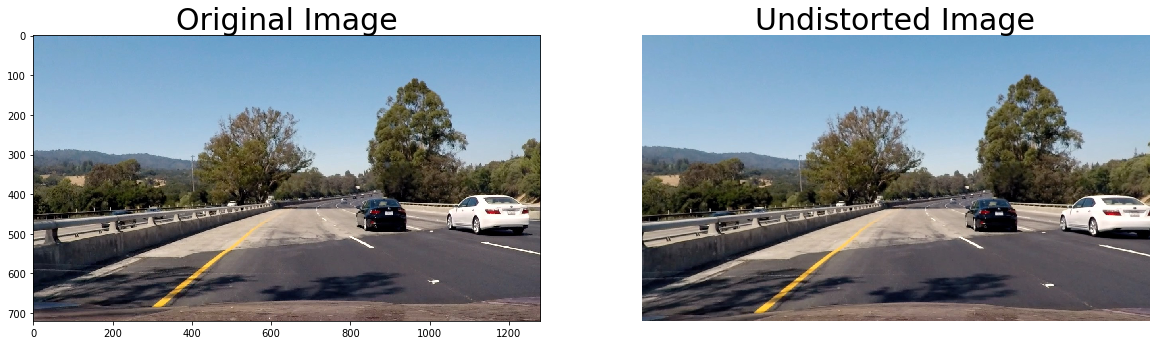

In [6]:
# Test undistortion on a road test image
road_img = cv2.imread('./test_images/test4.jpg')
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
undist_road = undistort(road_img)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(road_img)
ax3.set_title('Original Image', fontsize=30)
ax4.imshow(undist_road)
ax4.set_title('Undistorted Image', fontsize=30)
plt.axis('off')
# Uncomment below to save
plt.savefig('./output_images4/camera_calibration_road.jpg')

print('Done')

In [8]:
def warp(img, src, dst):
    h,w = (img.shape[0], img.shape[1])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

print('Done')

Done


## Perspective Transform

Done


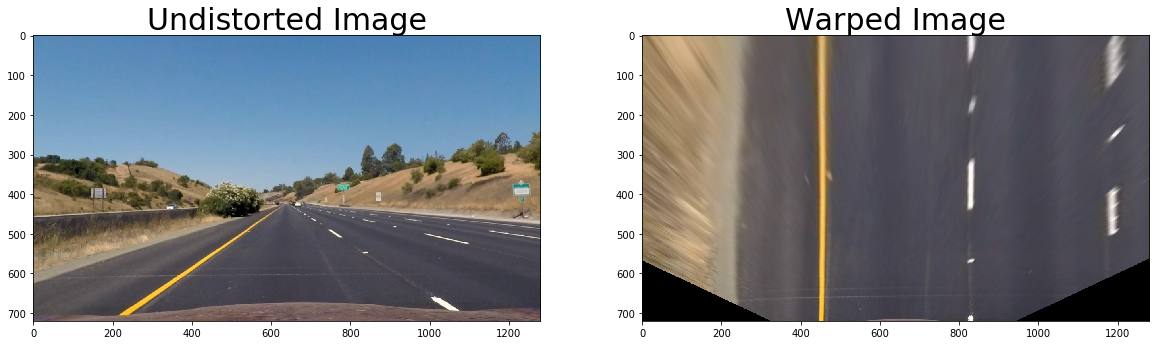

In [9]:
# Visualize perspective transform on example image
hwy = cv2.imread('test_images/test_straight_lines1.jpg')
hwy = cv2.cvtColor(hwy, cv2.COLOR_BGR2RGB)

undist_hwy = undistort(hwy)
h,w = undist_hwy.shape[:2]

# Define source and destination points for transform
src = np.float32([(575,464), (707,464), (258,682), (1049,682)])
dst = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])

warped_hwy, M, Minv = warp(undist_hwy, src, dst)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(undist_hwy)
ax3.set_title('Undistorted Image', fontsize=30)
ax4.imshow(warped_hwy)
ax4.set_title('Warped Image', fontsize=30)

# Uncomment below to save
plt.savefig('./output_images4/warped_road.jpg')

print('Done')

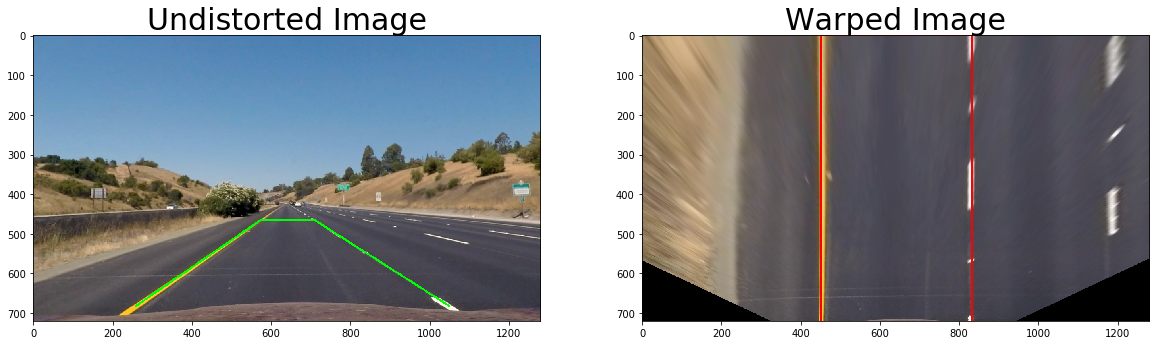

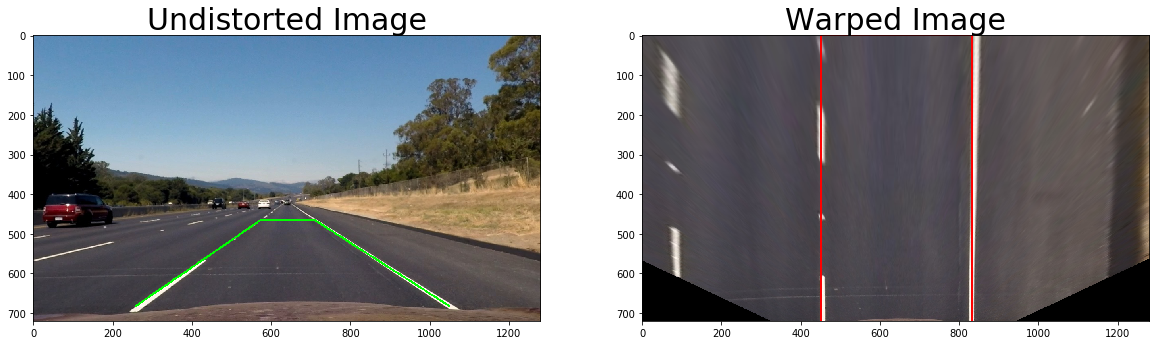

In [10]:
def draw_points(img, src, dst):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M, Minv = warp(undist, src, dst)
    undist_result = []
    warped_result = []
    for i in range(len(src)-1):
        cv2.line(undist, (src[i][0], src[i][1]), (src[i-1][0], src[i-1][1]), color=[0,255,0], thickness=3)
        undist_result.append(undist)

        cv2.line(warped, (dst[i][0], dst[i][1]), (dst[i-1][0], dst[i-1][1]), color=[255,0,0], thickness=3)
        warped_result.append(warped)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undist_result[-1])
    ax1.set_title('Undistorted Image', fontsize=30)
    ax2.imshow(warped_result[-1])
    ax2.set_title('Warped Image', fontsize=30)
    # Uncomment below to save
    plt.savefig('./output_images4/src_dst.jpg')

images = glob.glob('test_images/test_straight_lines*.jpg')
i = 0
fig = []
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h,w = img.shape[:2]
    src = np.float32([(575,464), (707,464), (1049,682), (258,682)])
    dst = np.float32([(450,0), (w-450,0), (w-450,h), (450,h)])

    draw_points(img, src, dst)

## Test Image

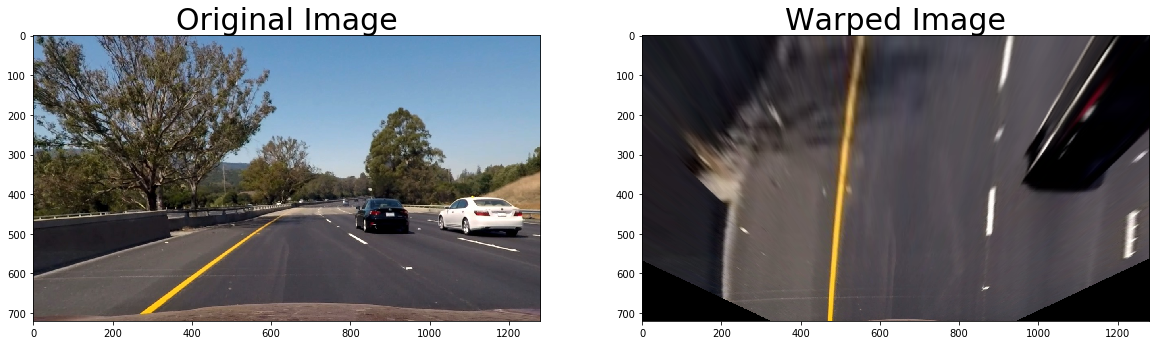

In [11]:
# Choose a sample image to run tests on
test_img = cv2.imread('./test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undist_test = undistort(test_img)

h,w = undist_test.shape[:2]

# Define source and destination points for transform
src = np.float32([(575,464), (707,464), (258,682), (1049,682)])
dst = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])

warped_test, M, Minv = warp(undist_test, src, dst)

f, (ax5, ax6) = plt.subplots(1, 2, figsize=(20,10))
ax5.imshow(undist_test)
ax5.set_title('Original Image', fontsize=30)
ax6.imshow(warped_test)
ax6.set_title('Warped Image', fontsize=30)

## Colorspace Testing

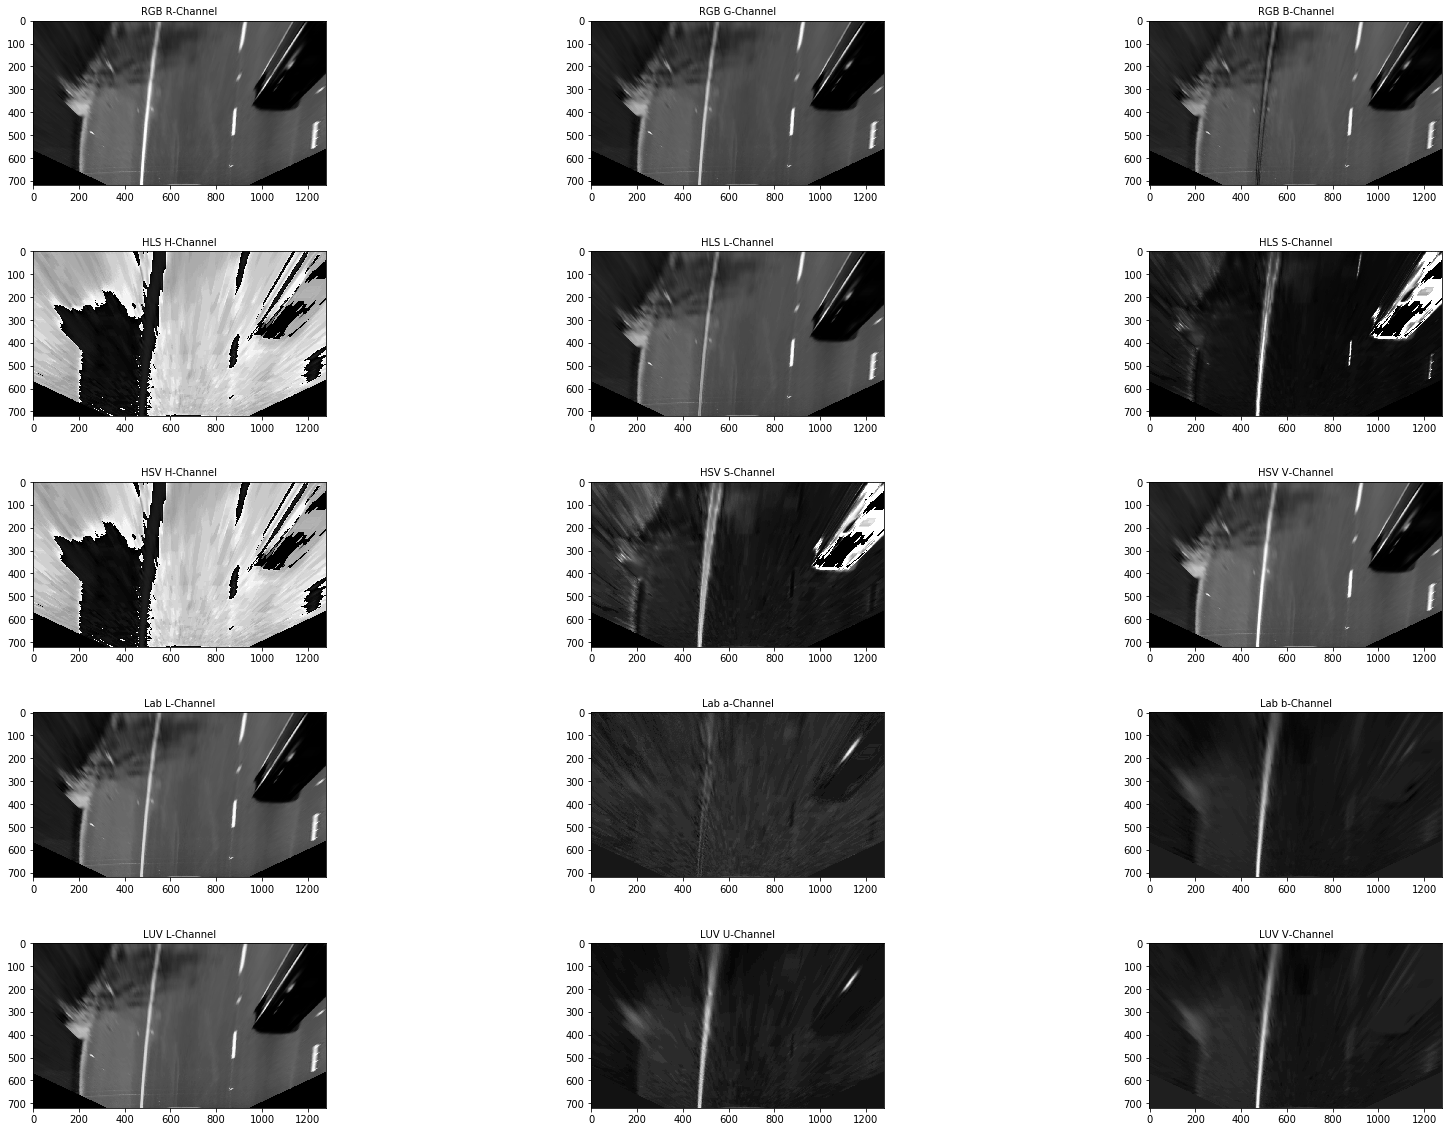

In [12]:
# Visualize multiple color space channels
r_channel = warped_test[:,:,0]
g_channel = warped_test[:,:,1]
rgb_bchannel = warped_test[:,:,2]

hls = cv2.cvtColor(warped_test, cv2.COLOR_RGB2HLS).astype(np.float)
hls_hchannel = hls[:,:,0]
hls_lchannel = hls[:,:,1]
hls_schannel = hls[:,:,2]

hsv = cv2.cvtColor(warped_test, cv2.COLOR_RGB2HSV).astype(np.float)
hsv_hchannel = hsv[:,:,0]
hsv_schannel = hsv[:,:,1]
hsv_vchannel = hsv[:,:,2]

lab = cv2.cvtColor(warped_test, cv2.COLOR_RGB2Lab).astype(np.float)
lab_lchannel = lab[:,:,0]
a_channel = lab[:,:,1]
lab_bchannel = lab[:,:,2]

luv = cv2.cvtColor(warped_test, cv2.COLOR_RGB2LUV).astype(np.float)
luv_lchannel = luv[:,:,0]
u_channel = luv[:,:,1]
luv_vchannel = luv[:,:,2]

fig, axs = plt.subplots(5, 3, figsize=(30, 20))
fig.subplots_adjust(hspace = .4, wspace=.001)
axs = axs.ravel()
axs[0].imshow(r_channel, cmap='gray')
axs[0].set_title('RGB R-Channel', fontsize=10)
axs[1].imshow(g_channel, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=10)
axs[2].imshow(rgb_bchannel, cmap='gray')
axs[2].set_title('RGB B-Channel', fontsize=10)
axs[3].imshow(hls_hchannel, cmap='gray')
axs[3].set_title('HLS H-Channel', fontsize=10)
axs[4].imshow(hls_lchannel, cmap='gray')
axs[4].set_title('HLS L-Channel', fontsize=10)
axs[5].imshow(hls_schannel, cmap='gray')
axs[5].set_title('HLS S-Channel', fontsize=10)
axs[6].imshow(hsv_hchannel, cmap='gray')
axs[6].set_title('HSV H-Channel', fontsize=10)
axs[7].imshow(hsv_schannel, cmap='gray')
axs[7].set_title('HSV S-Channel', fontsize=10)
axs[8].imshow(hsv_vchannel, cmap='gray')
axs[8].set_title('HSV V-Channel', fontsize=10)
axs[9].imshow(lab_lchannel, cmap='gray')
axs[9].set_title('Lab L-Channel', fontsize=10)
axs[10].imshow(a_channel, cmap='gray')
axs[10].set_title('Lab a-Channel', fontsize=10)
axs[11].imshow(lab_bchannel, cmap='gray')
axs[11].set_title('Lab b-Channel', fontsize=10)
axs[12].imshow(luv_lchannel, cmap='gray')
axs[12].set_title('LUV L-Channel', fontsize=10)
axs[13].imshow(u_channel, cmap='gray')
axs[13].set_title('LUV U-Channel', fontsize=10)
axs[14].imshow(luv_vchannel, cmap='gray')
axs[14].set_title('LUV V-Channel', fontsize=10)

## Sobel Absolute Thresholding

In [13]:
# lesson example: thresh=(20, 100)
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale / or LUV L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2LUV))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
    # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
    # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    binary_output = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

print('Done')

Done


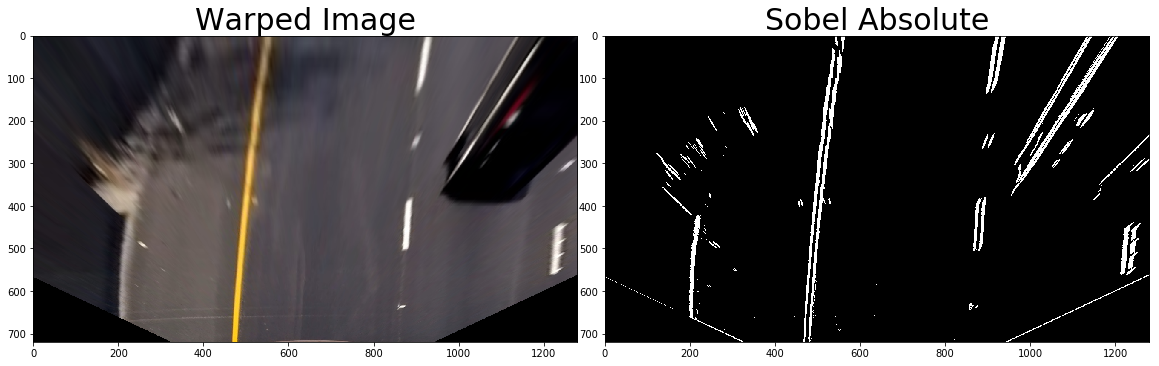

In [14]:
def update(thresh_min, thresh_max):
    test_img_sobelAbs = abs_sobel_thresh(warped_test, 'x', thresh_min, thresh_max)
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(warped_test)
    ax1.set_title('Warped Image', fontsize=30)
    ax2.imshow(test_img_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=30)

interact(update, thresh_min=(0,255), thresh_max=(0,255))

## Additional Gradient Thresholding Methods

In [15]:
# lesson example: sobel_kernel=9, mag_thresh=(30, 100)
def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# lesson example: sobel_kernel=15, thresh=(0.7, 1.3)
def dir_thresh(img, sobel_kernel=15, thresh=(0.7, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

print('Done')

Done


In [16]:
# Define a function that thresholds the L-channel of LUV
# Use exclusive lower bound (>) and inclusive upper (<=)
def luv_lthresh(img, thresh=(215, 255)):
    # 1) Convert to LUV color space
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(luv[:,:,0])
    binary_output[(luv[:,:,0] > thresh[0]) & (luv[:,:,0] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

print('Done')

Done


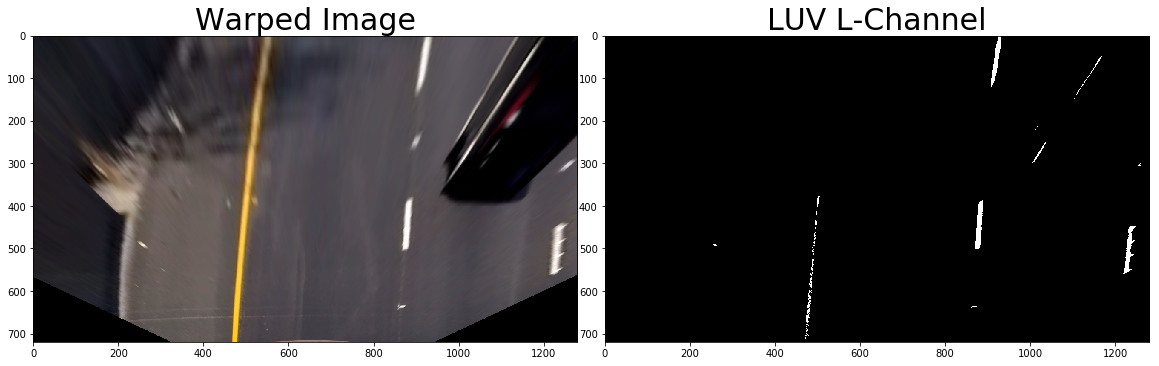

In [17]:
def update(thresh_min, thresh_max):
    test_img_lthresh = luv_lthresh(warped_test, (thresh_min, thresh_max))
    # Visualize LUV L-Channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(warped_test)
    ax1.set_title('Warped Image', fontsize=30)
    ax2.imshow(test_img_lthresh, cmap='gray')
    ax2.set_title('LUV L-Channel', fontsize=30)
                                   
interact(update, thresh_min=(0,255), thresh_max=(0,255))

In [18]:
# Define a function that thresholds the b-channel of Lab
# Use exclusive lower bound (>) and inclusive upper (<=)
def lab_bthresh(img, thresh=(147, 255)):
    # 1) Convert to Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    # 2) Apply a threshold to the b channel
    binary_output = np.zeros_like(lab[:,:,2])
    binary_output[(lab[:,:,2] > thresh[0]) & (lab[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

print('Done')

Done


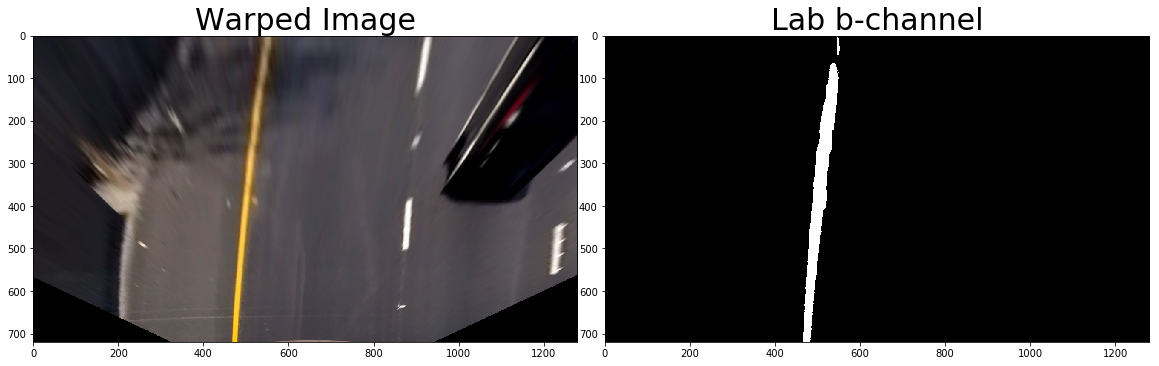

In [19]:
def update(thresh_min, thresh_max):
    test_img_bthresh = lab_bthresh(warped_test, (thresh_min, thresh_max))
    # Visualize Lab b-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(warped_test)
    ax1.set_title('Warped Image', fontsize=30)
    ax2.imshow(test_img_bthresh, cmap='gray')
    ax2.set_title('Lab b-channel', fontsize=30)
                                   
interact(update, thresh_min=(0,255), thresh_max=(0,255))

## Define Image Processing Pipeline

In [20]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines
def pipeline(img):
    # Undistort
    undist = undistort(img)
    
    # Perspective Transform
    warped, M, Minv = warp(undist, src, dst)
    
    # Sobel Absolute (using default parameters)
    #img_sobelabs = abs_sobel_thresh(warped)

    # Sobel Magnitude (using default parameters)
    #img_sobelmag = mag_thresh(warped)
    
    # Sobel Direction (using default parameters)
    #img_sobeldir = dir_thresh(warped)

    # LUV L-channel Threshold (using default parameters)
    img_lthresh = luv_lthresh(warped)

    # Lab b-channel Threshold (using default parameters)
    img_bthresh = lab_bthresh(warped)
    
    # Combine LUV and Lab b channel thresholds
    combined = np.zeros_like(img_bthresh)
    combined[(img_lthresh == 1) | (img_bthresh == 1)] = 1
    return combined, Minv
    
print('Done')

Done


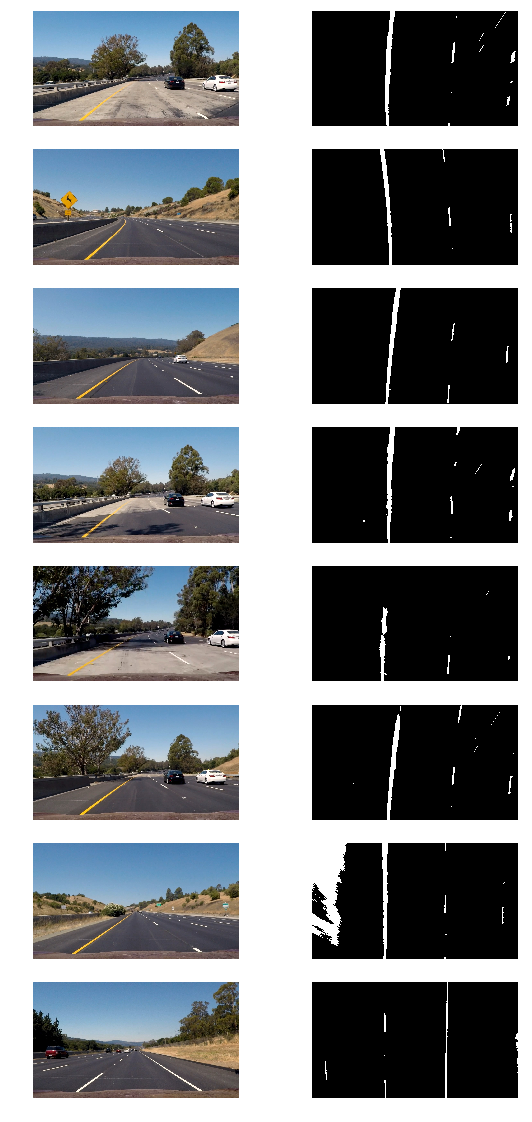

In [21]:
# Load all test images
images = glob.glob('./test_images/test*.jpg')

# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary_warped, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(binary_warped, cmap='gray')
    axs[i].axis('off')
    # Uncomment below to save
    #plt.savefig('./output_images4/binary.jpg')
    i += 1

## Locate the Lane Lines and Fit a Polynomial

In [43]:
# Define a method to fit a polynomial (using a sliding window) to a binary warped image with lane lines extracted
def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves and quarters of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    quadpoint = np.int(histogram.shape[0]/4)
    
    # These will be the starting point for the left and right lines
    leftx_base = np.argmax(histogram[quadpoint:midpoint]) + quadpoint
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quadpoint)]) + midpoint
    #print('leftx:', leftx_base)
    #print()
    #print('rightx:', rightx_base)
    
    # Choose the number of sliding windows
    nwindows = 10 #9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80 #100
    # Set minimum number of pixels found to recenter window
    minpix = 40 #50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Create an empty list for visualization purposes
    win_data = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        win_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
         
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #required for challenge vids
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    visual = (win_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visual

print('Done')

Done


## Visualization

(720, 0)

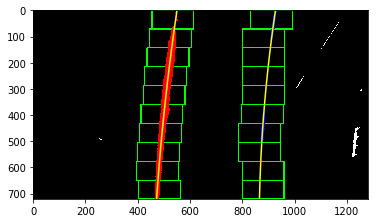

In [23]:
# Test images 6, 4 and 5 seem to be in chronological order so we will use two of these sequentially
test_img = cv2.imread('./test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
binary_test, Minv = pipeline(test_img)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visual = sliding_window(binary_test)

windows = visual[0]
histogram = visual[1]

#print(windows)

# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((binary_test, binary_test, binary_test))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_test.shape[0]-1, binary_test.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Draw the windows on the visualization image
for window in windows:
    cv2.rectangle(out_img,(window[2],window[0]),(window[3],window[1]),(0,255,0), 4) 
    cv2.rectangle(out_img,(window[4],window[0]),(window[5],window[1]),(0,255,0), 4)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_test.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(0, 1280)

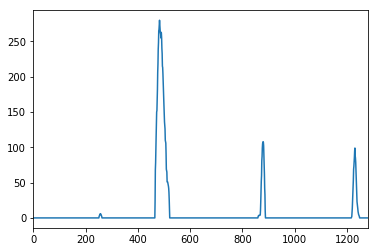

In [24]:
plt.plot(histogram)
plt.xlim(0, 1280)

## Polyfit Using Previous Frame

In [25]:
# Set up a method to fit polynomial to binary warped image based on fit from previous frame (no random search)
def secondary_polyfit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    
    left_lane_inds2 = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds2 = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds2]
    lefty = nonzeroy[left_lane_inds2] 
    rightx = nonzerox[right_lane_inds2]
    righty = nonzeroy[right_lane_inds2]
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit2 = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit2 = np.polyfit(righty, rightx, 2)
    
    return left_fit2, right_fit2, left_lane_inds2, right_lane_inds2

print('Done')

Done


## Visualization

(720, 0)

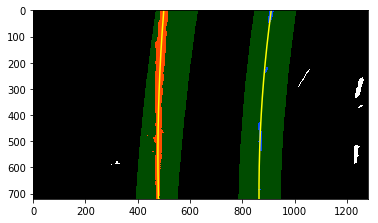

In [26]:
test_img2 = cv2.imread('./test_images/test4.jpg')
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
binary_test2, Minv = pipeline(test_img2)
    
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = secondary_polyfit(binary_test2, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_test2.shape[0]-1, binary_test2.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((binary_test2, binary_test2, binary_test2))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = binary_test2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

margin = 80

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Lane Curvature / Distance from Lane Center

In [27]:
# Set up a method to determine lane (radius of) curvature and distance from lane center
def lane_curve_n_center_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    # Lane is about 30 meters long and 3.7 meters wide
    ym_per_pix = 3.05/100 # meters per pixel in vertical axis; lane line is 10ft(3.05m)
    xm_per_pix = 3.7/380 # meters per pixel in horizontal axis; lane width is 12ft(3.7m)
    left_curverad, right_curverad, center_diff = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = binary_warped.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #print(lefty)
    #print(righty)
    #print()
    #print(ploty)
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x, y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is x axis midpoint - avg of left_fit and right_fit intercepts 
    if right_fit is not None and left_fit is not None:
        vehicle_position = binary_warped.shape[1]/2
        left_fit_x_intercept = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_intercept = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center = (right_fit_x_intercept + left_fit_x_intercept)/2
        center_diff = (vehicle_position - lane_center) * xm_per_pix
    
    return left_curverad, right_curverad, center_diff #, side_pos 

print('Done')

Done


In [28]:
# Test measurements
left_curverad, right_curverad, center_diff = lane_curve_n_center_dist(binary_test, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature: ' + str(round(left_curverad, 2)) + 'm, ' + str(round(right_curverad, 2)) + 'm')
print('Distance from lane center: ' + str(round(center_diff, 4)) + 'm')

Radius of curvature: 870.09m, 545.05m
Distance from lane center: -0.2818m


In [29]:
# Test measurements
left_curverad2, right_curverad2, center_diff2 = lane_curve_n_center_dist(binary_test2, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

print('Radius of curvature: ' + str(round(left_curverad2, 2)) + 'm, ' + str(round(right_curverad2, 2)) + 'm')
print('Distance from lane center: ' + str(round(center_diff2, 4)) + 'm')

Radius of curvature: 662.09m, 494.38m
Distance from lane center: -0.3066m


## Project Measurements onto Road

In [30]:
def draw_lane(orig_img, binary_img, left_fit, right_fit, Minv):
    new_img = np.copy(orig_img)
    if left_fit is None or right_fit is None:
        return orig_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h, w = binary_img.shape
    ploty = np.linspace(0, h-1, h)# create comparable y-range
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane and lane lines onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(128, 0, 128), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(128, 0, 128), thickness=20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    return result

print('Done')

Done


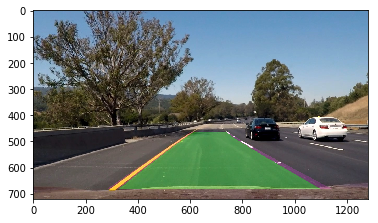

In [31]:
lane_img = draw_lane(test_img, binary_test, left_fit, right_fit, Minv)
plt.imshow(lane_img)

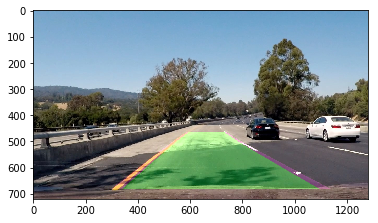

In [32]:
lane_img2 = draw_lane(test_img2, binary_test2, left_fit2, right_fit2, Minv)
plt.imshow(lane_img2)

In [33]:
def draw_data(orig_img, left_curverad, right_curverad, center_diff):
    new_img = np.copy(orig_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    font_size = 1.5
    color = (255, 255, 255)
    text = 'Curve Radius: ' + '{:04.2f}'.format((left_curverad + right_curverad)/2) + 'm'
    cv2.putText(new_img, text, (50, 100), font, font_size, color, 2)
    direction = ''
    if center_diff > 0:
        direction = 'Right'
    elif center_diff < 0:
        direction = 'Left'
    abs_center_diff = abs(center_diff)
    text = '{:04.3f}'.format(abs_center_diff) + 'm ' + direction + ' of Center'
    cv2.putText(new_img, text, (50, 150), font, font_size, color, 2)
    return new_img

print('Done')

Done


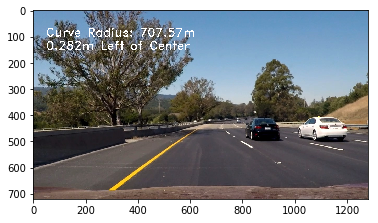

In [34]:
lane_data_img = draw_data(test_img, left_curverad, right_curverad, center_diff)
plt.imshow(lane_data_img)

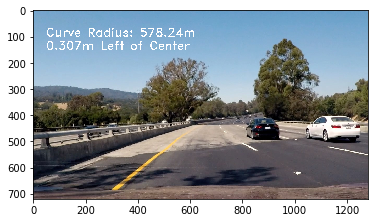

In [35]:
lane_data_img2 = draw_data(test_img2, left_curverad2, right_curverad2, center_diff2)
plt.imshow(lane_data_img2)

In [36]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # poor fit; disregard unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # only keep latest fits
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

print('Done')

Done


In [37]:
def process_image(img):
    new_img = np.copy(img)
    binary_warped, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use secondary_polyfit, otherwise use sliding_window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window(binary_warped)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = secondary_polyfit(binary_warped, l_line.best_fit, r_line.best_fit)
        
    # throw out both fits if the difference in their x-intercepts isn't +/- 100px from 400px
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_intercept = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_intercept = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_intercept_diff = abs(r_fit_x_intercept-l_fit_x_intercept)
        if abs(400 - x_intercept_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, binary_warped, l_line.best_fit, r_line.best_fit, Minv)
        l_rad, r_rad, center_diff = lane_curve_n_center_dist(binary_warped, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, l_rad, r_rad, center_diff)
    else:
        img_out = new_img
    
    return img_out

print('Done')

Done


## Project Video

In [46]:
l_line = Line()
r_line = Line()

output_video = 'output_project_vid4.mp4'
input_video = 'project_video.mp4'

clip1 = VideoFileClip(input_video) #.subclip(22,26) and (38,43)
video_clip = clip1.fl_image(process_image) # NOTE: this function requires COLOR images
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_project_vid4.mp4
[MoviePy] Writing video output_project_vid4.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<07:44,  2.71it/s]


  0%|          | 2/1261 [00:00<07:14,  2.90it/s]


  0%|          | 3/1261 [00:00<06:24,  3.27it/s]


  0%|          | 4/1261 [00:01<06:40,  3.14it/s]


  0%|          | 5/1261 [00:01<06:22,  3.28it/s]


  0%|          | 6/1261 [00:01<05:59,  3.49it/s]


  1%|          | 7/1261 [00:02<06:03,  3.45it/s]


  1%|          | 8/1261 [00:02<05:41,  3.67it/s]


  1%|          | 9/1261 [00:02<05:32,  3.76it/s]


  1%|          | 10/1261 [00:02<05:27,  3.82it/s]


  1%|          | 11/1261 [00:03<05:18,  3.93it/s]


  1%|          | 12/1261 [00:03<05:18,  3.92it/s]


  1%|          | 13/1261 [00:03<05:27,  3.81it/s]


  1%|          | 14/1261 [00:03<05:43,  3.63it/s]


  1%|          | 15/1261 [00:04<05:24,  3.84it/s]


  1%|▏         | 16/1261 [00:04<05:36,  3.70it/s]


  1%|▏         | 17/1261 [00:04<05:22,  3.85it/s]


  1%|▏         | 18/1261 [00:04<05:12,  3.98it/s]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_vid4.mp4 

CPU times: user 4min 25s, sys: 1min 13s, total: 5min 39s
Wall time: 5min 10s


## Challenge Video

In [44]:
l_line = Line()
r_line = Line()

output_video = 'output_challenge.mp4'
input_video = 'challenge_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(process_image) # NOTE: this function requires COLOR images
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_challenge.mp4
[MoviePy] Writing video output_challenge.mp4





  0%|          | 0/485 [00:00<?, ?it/s]


  0%|          | 1/485 [00:00<02:47,  2.89it/s]


  0%|          | 2/485 [00:00<02:29,  3.24it/s]


  1%|          | 3/485 [00:00<02:22,  3.39it/s]


  1%|          | 4/485 [00:01<02:08,  3.73it/s]


  1%|          | 5/485 [00:01<01:58,  4.06it/s]


  1%|          | 6/485 [00:01<02:07,  3.77it/s]


  1%|▏         | 7/485 [00:01<02:01,  3.94it/s]


  2%|▏         | 8/485 [00:02<01:59,  3.99it/s]


  2%|▏         | 9/485 [00:02<01:56,  4.10it/s]


  2%|▏         | 10/485 [00:02<01:51,  4.27it/s]


  2%|▏         | 11/485 [00:02<01:47,  4.40it/s]


  2%|▏         | 12/485 [00:02<01:49,  4.32it/s]


  3%|▎         | 13/485 [00:03<01:45,  4.46it/s]


  3%|▎         | 14/485 [00:03<01:46,  4.44it/s]


  3%|▎         | 15/485 [00:03<01:47,  4.37it/s]


  3%|▎         | 16/485 [00:03<01:50,  4.26it/s]


  4%|▎         | 17/485 [00:04<01:48,  4.30it/s]


  4%|▎         | 18/485 [00:04<01:51,  4.18it/s]


  4%|▍         | 19/485 [00:04<01:47,  4.34it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge.mp4 

CPU times: user 1min 39s, sys: 18.2 s, total: 1min 57s
Wall time: 1min 49s


## Harder Challenge Video

In [45]:
l_line = Line()
r_line = Line()

output_video = 'output_harder_challenge.mp4'
input_video = 'harder_challenge_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(process_image) # NOTE: this function requires COLOR images
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_harder_challenge.mp4
[MoviePy] Writing video output_harder_challenge.mp4





  0%|          | 0/1200 [00:00<?, ?it/s]


  0%|          | 1/1200 [00:00<10:40,  1.87it/s]


  0%|          | 2/1200 [00:00<09:38,  2.07it/s]


  0%|          | 3/1200 [00:01<09:10,  2.18it/s]


  0%|          | 4/1200 [00:01<08:28,  2.35it/s]


  0%|          | 5/1200 [00:02<08:03,  2.47it/s]


  0%|          | 6/1200 [00:02<08:09,  2.44it/s]


  1%|          | 7/1200 [00:02<08:40,  2.29it/s]


  1%|          | 8/1200 [00:03<08:42,  2.28it/s]


  1%|          | 9/1200 [00:03<08:24,  2.36it/s]


  1%|          | 10/1200 [00:04<08:17,  2.39it/s]


  1%|          | 11/1200 [00:04<08:13,  2.41it/s]


  1%|          | 12/1200 [00:05<10:01,  1.98it/s]


  1%|          | 13/1200 [00:05<09:03,  2.18it/s]


  1%|          | 14/1200 [00:06<08:31,  2.32it/s]


  1%|▏         | 15/1200 [00:06<08:12,  2.41it/s]


  1%|▏         | 16/1200 [00:06<07:55,  2.49it/s]


  1%|▏         | 17/1200 [00:07<08:59,  2.19it/s]


  2%|▏         | 18/1200 [00:07<08:43,  2.26it/s]


  2%|▏         | 19/1200 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge.mp4 

CPU times: user 4min 55s, sys: 1min 13s, total: 6min 9s
Wall time: 6min 16s
